In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import datetime
import time
from wordcloud import WordCloud

## ÎπÑÌä∏ÏΩîÏù∏Í≥º ÏïàÏ†ïÏûêÏÇ∞, ÏúÑÌóòÏûêÏÇ∞Ïùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù
- Îç∞Ïù¥ÌÑ∞ ÏÇ∞Ï∂ú Í∏∞Í∞Ñ
    - Ï†úÎèÑ Ìé∏ÏûÖ Ï†Ñ : 2014.09.01 ~ 2019.12.31
    - Ï†úÎèÑ Ìé∏ÏûÖ ÌõÑ : 2021.01.01 ~ 2024.06.06
- ÏïàÏ†ÑÏûêÏÇ∞ ÎπÑÍµêÍµ∞ : Í∏à, Îã¨Îü¨
- ÏúÑÌóòÏûêÏÇ∞ ÎπÑÍµêÍµ∞ : ÏõêÏú†
- Îç∞Ïù¥ÌÑ∞ Ï∂úÏ≤ò : Yahoo Finance

In [2]:
# Í∏∞Í∞Ñ
start_date = "2021-01-01"
end_date = "2024-06-06"
# ÎπÑÌä∏ÏΩîÏù∏Í≥º ÏïàÏ†ÑÏûêÏÇ∞(Í∏à)Ïùò Î≥ÄÎèôÏÑ± ÏßëÏ§ë Í∏∞Í∞Ñ Î¶¨Ïä§Ìä∏
news_date_list = ["2022.03.28", "2022.11.14", "2023.04.03", "2024.01.08", "2024.03.25", "2024.05.06"]

# Ï¢ÖÎ™©
bitcoin = "BTC-USD"
gold = "GC=F"
usd = "EURUSD=X"
wti = "CL=F"

# ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
def ticker_data(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de)
    result["change"] = result["Adj Close"].diff()
    result["daily_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna() # NaN Ìè¨Ìï® Ìñâ ÏÇ≠Ï†ú
    return result

# Ï£ºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
def ticker_data_wk(tk_name, ds, de) : 
    result = yf.download(tk_name, ds, de, interval = "1wk")
    result["weekly_return"] = result["Adj Close"].pct_change()*100
    result = result.dropna()
    return result

# ÏùºÎ≥Ñ ÏàòÏ†ï Ï¢ÖÍ∞Ä (Adj Close) Ï∂îÏ∂ú Ìï®Ïàò
def daily_adj_close(tk_name, ds, de) :
    result = yf.download(tk_name, ds, de)
    return result["Adj Close"]

# ÏùºÎ≥Ñ ÏàòÏùµÎ•† (daily_return) Ï∂îÏ∂ú Ìï®Ïàò
def daily_return_rate(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de)
    return result["daily_return"]

# Ï£ºÍ∞Ñ ÏàòÏùµÎ•† (weekly_return) Ï∂îÏ∂ú Ìï®Ïàò
def weekly_return_rate(tk_name, ds, de) :
    result = ticker_data_wk(tk_name, ds, de)
    return result["weekly_return"]

# ÎπÑÌä∏ÏΩîÏù∏Í≥º Ìã∞Ïª§ Í∞ÑÏùò ÏÉÅÍ¥ÄÏÑ± ÏÇ∞Ï∂ú
def corr_bit(tk_name, ds, de) :
    result = weekly_return_rate(bitcoin, ds, de) / weekly_return_rate(tk_name, ds, de)
    result = result.dropna()
    return result

# Í≥ÑÏÇ∞Ïãù for ÏÑ†Ìòï ÌöåÍ∑Ä
def lin_cal(tk_name, ds, de) :
    tk2024 = ticker_data(tk_name, ds, de) # Ï†úÎèÑ Ìé∏ÏûÖ ÌõÑ Í∏∞Í∞ÑÏùò Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    std2024 = tk2024[tk2024.index == "2024-06-04"] # Í∏∞Ï§ÄÏù¥ ÎêòÎäî ÎÇ†ÏßúÏùò Ìñâ Ï∂îÏ∂ú
    std2024 = std2024["Adj Close"].values[0] # Ìï¥Îãπ ÌñâÏùò ÏàòÏ†ï Ï¢ÖÍ∞Ä
    result = (ticker_data(tk_name, ds, de)["Adj Close"] / std2024) * 100 # Ìã∞Ïª§Ïùò ÏàòÏ†ï Ï¢ÖÍ∞Ä Ïª¨ÎüºÍ≥º Ïó∞ÏÇ∞
    return result

# Ìã∞Ïª§ ÏÉùÏÑ± Ïãú Ìò∏Ï∂ú Ìï®Ïàò
def ticker_call(tk_name, ds, de) :
    result = ticker_data(tk_name, ds, de) # ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
    result["chg_rat_exp_2024"] = lin_cal(tk_name, ds, de) # ÏÑ†Ìòï ÌöåÍ∑Ä ÏÇ∞Ï∂úÏùÑ ÏúÑÌï¥ Ïó∞ÏÇ∞Îêú Ïª¨Îüº Ï∂îÍ∞Ä
    return result

# ÏÑ†Ìòï ÌöåÍ∑Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
def lin_data(tk_name, ds, de) :
    bit_col = ticker_call(bitcoin, ds, de)["chg_rat_exp_2024"]
    tk_col = ticker_call(tk_name, ds, de)["chg_rat_exp_2024"]
    
    result = pd.concat([bit_col, tk_col], axis = 1)
    result.columns = ["bit", "tk"]
    result = result.dropna()
    
    model = stats.linregress(result["bit"], result["tk"]) # ÏÑ†Ìòï ÌöåÍ∑Ä Í≥ÑÏàò Í∞ùÏ≤¥ ÏÉùÏÑ±
    dict_lin = {
        "slope" : model.slope,
        "intercept" : model.intercept,
        "rvalue" : model.rvalue,
        "pvalue" : model.pvalue,
        "stderr" : model.stderr,
        "intercept_stderr" : model.intercept_stderr
    }
    result_lin = pd.DataFrame(list(dict_lin.values()), index = dict_lin.keys())
    return result_lin

In [3]:
# ÎπÑÌä∏ÏΩîÏù∏Ïùò ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
bit_ticker = ticker_call(bitcoin, start_date, end_date)
bit_ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open          High           Low         Close  \
Date                                                                 
2021-01-02  29376.455078  33155.117188  29091.181641  32127.267578   
2021-01-03  32129.408203  34608.558594  32052.316406  32782.023438   
2021-01-04  32810.949219  33440.218750  28722.755859  31971.914062   
2021-01-05  31977.041016  34437.589844  30221.187500  33992.429688   
2021-01-06  34013.613281  36879.699219  33514.035156  36824.363281   
...                  ...           ...           ...           ...   
2024-06-01  67489.609375  67839.765625  67386.195312  67706.937500   
2024-06-02  67710.273438  68409.164062  67315.523438  67751.601562   
2024-06-03  67753.898438  70230.820312  67589.835938  68804.781250   
2024-06-04  68804.570312  71047.406250  68564.640625  70567.765625   
2024-06-05  70568.351562  71735.414062  70390.710938  71082.820312   

               Adj Close       Volume       change  daily_return  \
Date                                                               
2021-01-02  32127.267578  67865420765  2753.115234      9.372578   
2021-01-03  32782.023438  78665235202   654.755859      2.038007   
2021-01-04  31971.914062  81163475344  -810.109375     -2.471200   
2021-01-05  33992.429688  67547324782  2020.515625      6.319658   
2021-01-06  36824.363281  75289433811  2831.933594      8.331071   
...                  ...          ...          ...           ...   
2024-06-01  67706.937500  11641495604   215.523438      0.319335   
2024-06-02  67751.601562  17110588415    44.664062      0.065967   
2024-06-03  68804.781250  32401285324  1053.179688      1.554472   
2024-06-04  70567.765625  33149696545  1762.984375      2.562299   
2024-06-05  71082.820312  32810771409   515.054688      0.729872   

            chg_rat_exp_2024  
Date                          
2021-01-02         45.526831  
2021-01-03         46.454671  
2021-01-04         45.306683  
2021-01-05         48.169911  
2021-01-06         52.182980  
...                      ...  
2024-06-01         95.945985  
2024-06-02         96.009277  
2024-06-03         97.501714  
2024-06-04        100.000000  
2024-06-05        100.729872  

[1251 rows x 9 columns]

In [4]:
# ÎπÑÍµêÍµ∞ ÏùºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
ticker = ticker_call(usd, start_date, end_date)
ticker

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2021-01-04  1.224905  1.230999  1.217137  1.225070   1.225070       0   
2021-01-05  1.225295  1.229483  1.224995  1.225160   1.225160       0   
2021-01-06  1.229861  1.235025  1.226693  1.230027   1.230027       0   
2021-01-07  1.233776  1.234568  1.224665  1.234111   1.234111       0   
2021-01-08  1.226873  1.228215  1.221493  1.227144   1.227144       0   
...              ...       ...       ...       ...        ...     ...   
2024-05-30  1.080182  1.084599  1.078900  1.080182   1.080182       0   
2024-05-31  1.083541  1.088258  1.081163  1.083541   1.083541       0   
2024-06-03  1.085305  1.089087  1.082802  1.085305   1.085305       0   
2024-06-04  1.090739  1.091822  1.086071  1.090739   1.090739       0   
2024-06-05  1.088187  1.088992  1.086095  1.088187   1.088187       0   

              change  daily_return  chg_rat_exp_2024  
Date                                                  
2021-01-04  0.007043      0.578221        112.315621  
2021-01-05  0.000090      0.007356        112.323884  
2021-01-06  0.004868      0.397299        112.770146  
2021-01-07  0.004083      0.331976        113.144516  
2021-01-08 -0.006966     -0.564484        112.505833  
...              ...           ...               ...  
2024-05-30 -0.005005     -0.461233         99.032162  
2024-05-31  0.003359      0.310973         99.340126  
2024-06-03  0.001764      0.162794         99.501846  
2024-06-04  0.005434      0.500648        100.000000  
2024-06-05 -0.002552     -0.233962         99.766038  

[893 rows x 9 columns]

## ÌÜµÍ≥ÑÏ†Å ÏàòÏπòÎ•º ÏúÑÌïú Îã®Ïàú ÏÑ†Ìòï ÌöåÍ∑Ä
- Í∏∞Ïö∏Í∏∞ (Slope)
- Ï†àÌé∏ (Intercept)
- ÏÉÅÍ¥ÄÍ≥ÑÏàò (R-value)
    - 1 : ÏôÑÎ≤ΩÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ. Îëê Î≥ÄÏàòÎäî ÏôÑÎ≤ΩÌïòÍ≤å ÎπÑÎ°ÄÌï¥ÏÑú Ï¶ùÍ∞Ä
    - 0.7 ~ 0.9 : Í∞ïÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - 0.5 ~ 0.7 : Ï§ëÍ∞Ñ Ï†ïÎèÑÏùò ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - 0.3 ~ 0.5 : ÏïΩÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - 0 : ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏóÜÏùå
    - -0.3 ~ -0.5 : ÏïΩÌïú ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - -0.5 ~ -0.7 : Ï§ëÍ∞Ñ Ï†ïÎèÑÏùò ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - -0.7 ~ -0.9 : Í∞ïÌïú ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ
    - -1 : ÏôÑÎ≤ΩÌïú ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ. Îëê Î≥ÄÏàòÎäî ÏôÑÎ≤ΩÌïòÍ≤å Î∞òÎπÑÎ°ÄÌï¥ÏÑú Î≥ÄÌôî
- Ïú†ÏùòÌôïÎ•† (P-value) : ÏùºÎ∞òÏ†ÅÏúºÎ°ú P-valueÍ∞Ä 0.05Î≥¥Îã§ ÏûëÏúºÎ©¥ Í≤∞Í≥ºÍ∞Ä ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Ïú†ÏùòÎØ∏ÌïòÎã§Í≥† ÌåêÎã®
- ÌëúÏ§ÄÏò§Ï∞® (Standard Error)
- Ï†àÌé∏Ïùò ÌëúÏ§ÄÏò§Ï∞® (Intercept Standard Error)

#### ‚úÖ ÏïàÏ†Ñ/ÏïàÏ†ïÏ†Å ÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- iShares 20+ Year Treasury Bond ETF : ÎØ∏Íµ≠ Íµ≠Ï±Ñ ETF, ÎØ∏Íµ≠Ïùò Ïû•Í∏∞ Íµ≠Ï±ÑÏóê Ìà¨ÏûêÌïòÏó¨ ÏïàÏ†ïÏ†ÅÏù∏ ÏàòÏùµÏùÑ Ï∂îÍµ¨, Ï¢ÖÎ™©ÏΩîÎìú "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : ÎØ∏Íµ≠ Ìà¨ÏûêÎì±Í∏â ÌöåÏÇ¨Ï±ÑÏóê Ìà¨ÏûêÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "LQD"
- Duke Energy : Ï†ÑÎ†• Î∞è Ï≤úÏó∞Í∞ÄÏä§ ÏÑúÎπÑÏä§Î•º Ï†úÍ≥µÌïòÎäî Ïú†Ìã∏Î¶¨Ìã∞ Î∂ÄÎ¨∏ Í≥µÍ≥µ Ï£ºÏãù, Ï¢ÖÎ™©ÏΩîÎìú "DUK"
- Gold ETF : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Í∏à Í∞ÄÍ≤©Ïóê Ïó∞ÎèôÎêòÏñ¥ Í∏àÏóê Ìà¨ÏûêÌïòÎäî Ìö®Í≥ºÎ•º Ï†úÍ≥µÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "GLD"

#### ‚úÖ ÏúÑÌóò ÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- Brent oil :  Ï¢ÖÎ™©ÏΩîÎìú "BZ=F"
- Tesla :  Ï¢ÖÎ™©ÏΩîÎìú "TSLA"
- Dow Jones Industrial Average : Îã§Ïö∞Ï°¥Ïä§ ÏÇ∞ÏóÖ ÌèâÍ∑† ÏßÄÏàò, Ï£ºÎ°ú ÎåÄÌòï Í∏∞ÏóÖÎì§Î°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏñ¥, ÏãúÏû• Ï†ÑÏ≤¥Î≥¥Îã§Îäî Ï£ºÎ°ú ÎåÄÌòïÏ£º Î∞è ÏÇ∞ÏóÖÏùÑ ÎåÄÌëú, Ï¢ÖÎ™©ÏΩîÎìú "^DJI"
- Nasdaq-100 Index : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "QQQ"
- Emerging Markets ETF : Ï§ëÍµ≠, Ïù∏ÎèÑ, Î∏åÎùºÏßà Îì± Ïã†Ìù• ÏãúÏû•Ïùò Ï£ºÏãùÏóê Ìà¨ÏûêÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "EEM"

In [5]:
# ÏÑ†Ìòï ÌöåÍ∑Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
# ÏïàÏ†Ñ ÏûêÏÇ∞, ÏïàÏ†ïÏ†Å ÏûêÏÇ∞
gold_lin = lin_data(gold, start_date, end_date)
tlt_lin = lin_data("TLT", start_date, end_date)
lqd_lin = lin_data("LQD", start_date, end_date)
duk_lin = lin_data("DUK", start_date, end_date)
gold_etf_lin = lin_data("GLD", start_date, end_date)
usd_lin = lin_data(usd, start_date, end_date)
# ÏúÑÌóò ÏûêÏÇ∞
wti_lin = lin_data(wti, start_date, end_date)
brent_lin = lin_data("BZ=F", start_date, end_date)
tsla_lin = lin_data("TSLA", start_date, end_date)
dj_lin = lin_data("^DJI", start_date, end_date)
nasdq_lin = lin_data("QQQ", start_date, end_date)
em_etf_lin = lin_data("EEM", start_date, end_date)

df_lin = pd.concat([gold_lin, tlt_lin, lqd_lin, duk_lin, gold_etf_lin, usd_lin, wti_lin, brent_lin, tsla_lin, dj_lin, nasdq_lin, em_etf_lin], axis = 1)
df_lin.columns = ["Gold", "US ETF", "US CP ETF", "Duke", "Gold ETF", "EUR/USD", "WTI", "Brent", "Tesla", "Dow Jones", "Nasdaq-100 Index", "Emerging Markets ETF"]
df_lin

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Gold        US ETF     US CP ETF       Duke  \
slope             1.425926e-01  2.921022e-01  2.141553e-01  -0.001993   
intercept         7.359487e+01  1.032669e+02  8.941708e+01  87.917008   
rvalue            4.476186e-01  3.085052e-01  5.633886e-01  -0.007152   
pvalue            1.187240e-43  2.028845e-20  3.456775e-73   0.834113   
stderr            9.719387e-03  3.074757e-02  1.072156e-02   0.009514   
intercept_stderr  5.599123e-01  1.771463e+00  6.177025e-01   0.548108   

                      Gold ETF       EUR/USD           WTI         Brent  \
slope             1.435703e-01  1.379034e-01 -2.170310e-01 -2.402732e-01   
intercept         7.405801e+01  9.373964e+01  1.206953e+02  1.212636e+02   
rvalue            4.646572e-01  5.072604e-01 -2.473752e-01 -2.858009e-01   
pvalue            2.818245e-47  1.459521e-59  1.800018e-13  1.251743e-17   
stderr            9.340546e-03  7.848884e-03  2.900393e-02  2.750392e-02   
intercept_stderr  5.381378e-01  4.517490e-01  1.670852e+00  1.583775e+00   

                       Tesla      Dow Jones  Nasdaq-100 Index  \
slope               0.210197   1.835888e-01      3.725985e-01   
intercept         125.547873   7.877989e+01      5.594804e+01   
rvalue              0.135679   6.603623e-01      7.224767e-01   
pvalue              0.000066  7.717484e-109     1.150899e-139   
stderr              0.052401   7.127374e-03      1.217307e-02   
intercept_stderr    3.018965   4.106301e-01      7.013281e-01   

                  Emerging Markets ETF  
slope                     3.444553e-01  
intercept                 8.292011e+01  
rvalue                    5.622671e-01  
pvalue                    7.652674e-73  
stderr                    1.729533e-02  
intercept_stderr          9.964375e-01

## Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


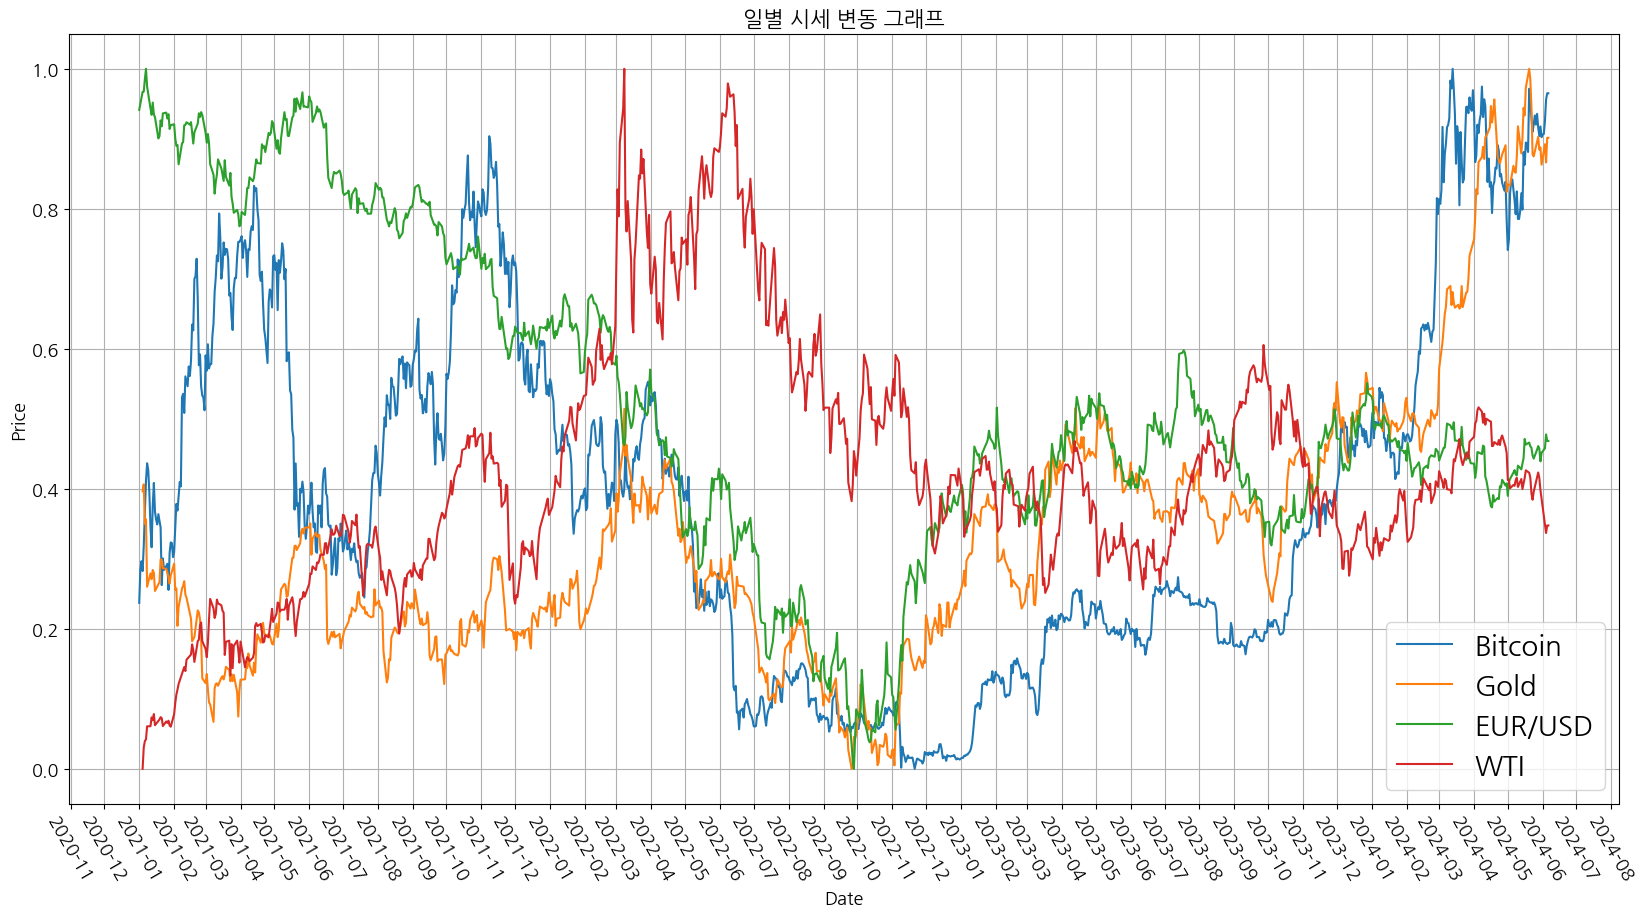

In [6]:
# daily price change graph
scaler = MinMaxScaler()
all_dates = pd.date_range(start = start_date, end = end_date, freq = "D")

# interpolate() : Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ
y1_series = daily_adj_close(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
y2_series = daily_adj_close(gold, start_date, end_date).reindex(all_dates).interpolate()
y3_series = daily_adj_close(usd, start_date, end_date).reindex(all_dates).interpolate()
y4_series = daily_adj_close(wti, start_date, end_date).reindex(all_dates).interpolate()

# Ïä§ÏºÄÏùºÎßÅÌï† Îç∞Ïù¥ÌÑ∞ Î™®Ïñë Î≥ÄÍ≤Ω
y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = y1_series.index # ÎÇ†Ïßú Ï∂îÏ∂ú

plt.rc("font", family="NanumGothic", size=13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(20, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc="best", prop={"size": 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=300)
plt.grid(True)
plt.title("ÏùºÎ≥Ñ ÏãúÏÑ∏ Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


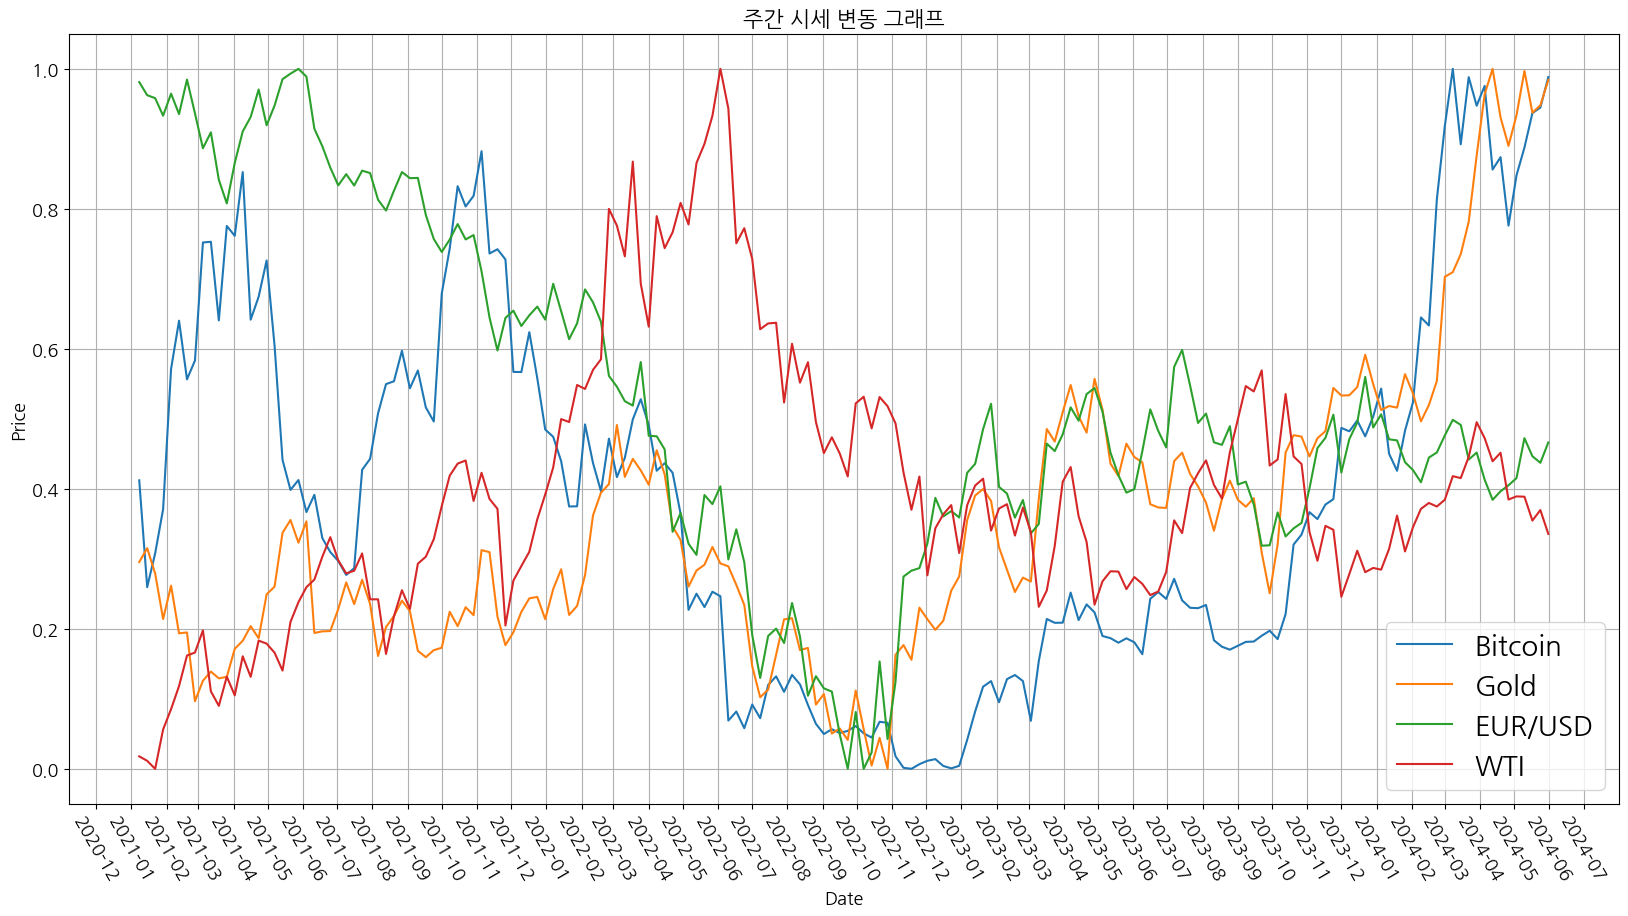

In [7]:
# weekly price change graph
y1_wk = ticker_data_wk(bitcoin, start_date, end_date)["Adj Close"]
y2_wk = ticker_data_wk(gold, start_date, end_date)["Adj Close"]
y3_wk = ticker_data_wk(usd, start_date, end_date)["Adj Close"]
y4_wk = ticker_data_wk(wti, start_date, end_date)["Adj Close"]

# Ïä§ÏºÄÏùºÎßÅÌï† Îç∞Ïù¥ÌÑ∞ Î™®Ïñë Î≥ÄÍ≤Ω
y1 = y1_wk.values.reshape(-1, 1)
y2 = y2_wk.values.reshape(-1, 1)
y3 = y3_wk.values.reshape(-1, 1)
y4 = y4_wk.values.reshape(-1, 1)

dates = y1_wk.index # ÎÇ†Ïßú Ï∂îÏ∂ú

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(y1_wk.index, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(y2_wk.index, scaler.fit_transform(y2), label = "Gold")
plt.plot(y3_wk.index, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(y4_wk.index, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Price")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("Ï£ºÍ∞Ñ ÏãúÏÑ∏ Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


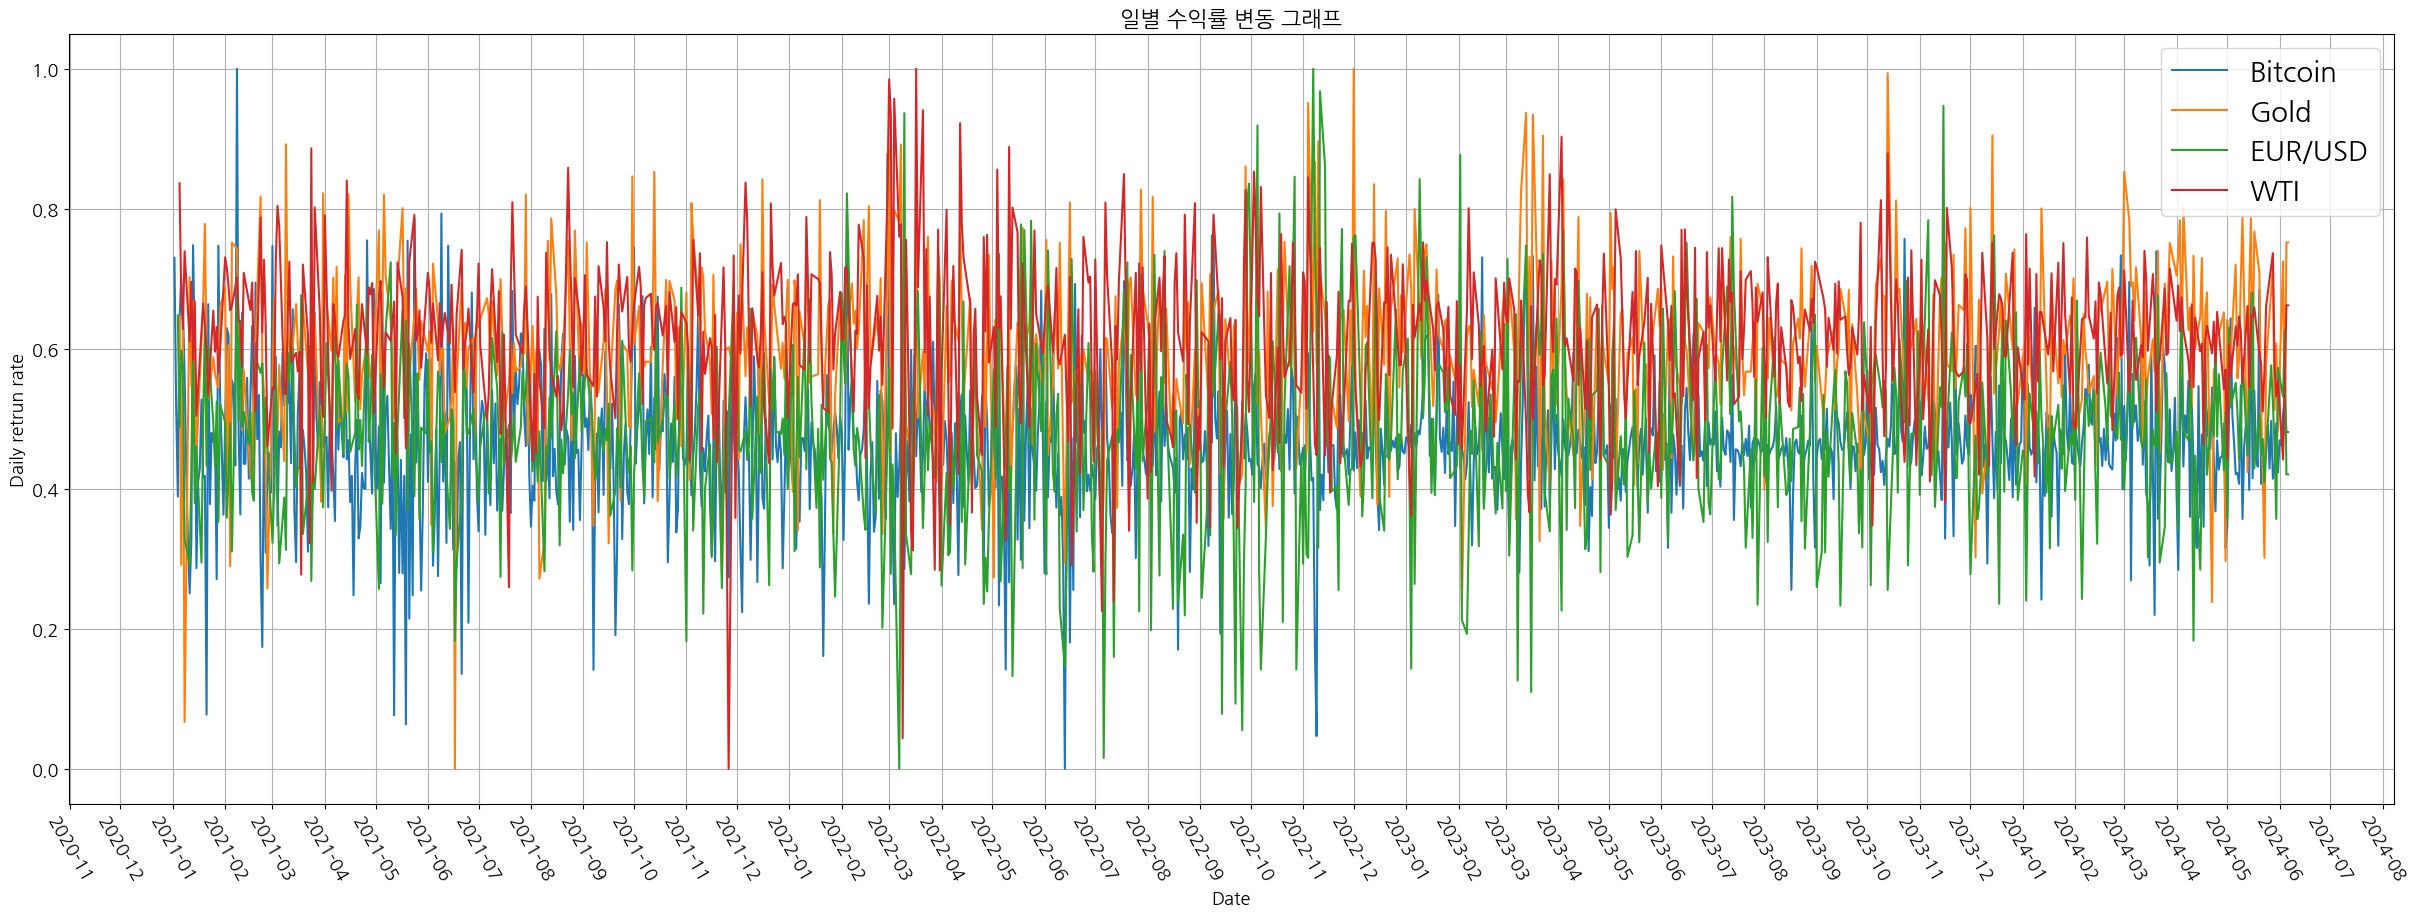

In [8]:
# daily return rate change graph
# ÏùºÎ≥Ñ ÏàòÏùµÎ•†(=Ï¶ùÍ∞êÎ•†)Ïùò Î≥ÄÎèôÏÑ± ÌôïÏù∏
# interpolate() : Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ
d_y1 = daily_return_rate(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
d_y2 = daily_return_rate(gold, start_date, end_date).reindex(all_dates).interpolate()
d_y3 = daily_return_rate(usd, start_date, end_date).reindex(all_dates).interpolate()
d_y4 = daily_return_rate(wti, start_date, end_date).reindex(all_dates).interpolate()


# Ïä§ÏºÄÏùºÎßÅÌï† Îç∞Ïù¥ÌÑ∞ Î™®Ïñë Î≥ÄÍ≤Ω
y1 = d_y1.values.reshape(-1, 1)
y2 = d_y2.values.reshape(-1, 1)
y3 = d_y3.values.reshape(-1, 1)
y4 = d_y4.values.reshape(-1, 1)

dates = d_y1.index # ÎÇ†Ïßú Ï∂îÏ∂ú

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (30, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("ÏùºÎ≥Ñ ÏàòÏùµÎ•† Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


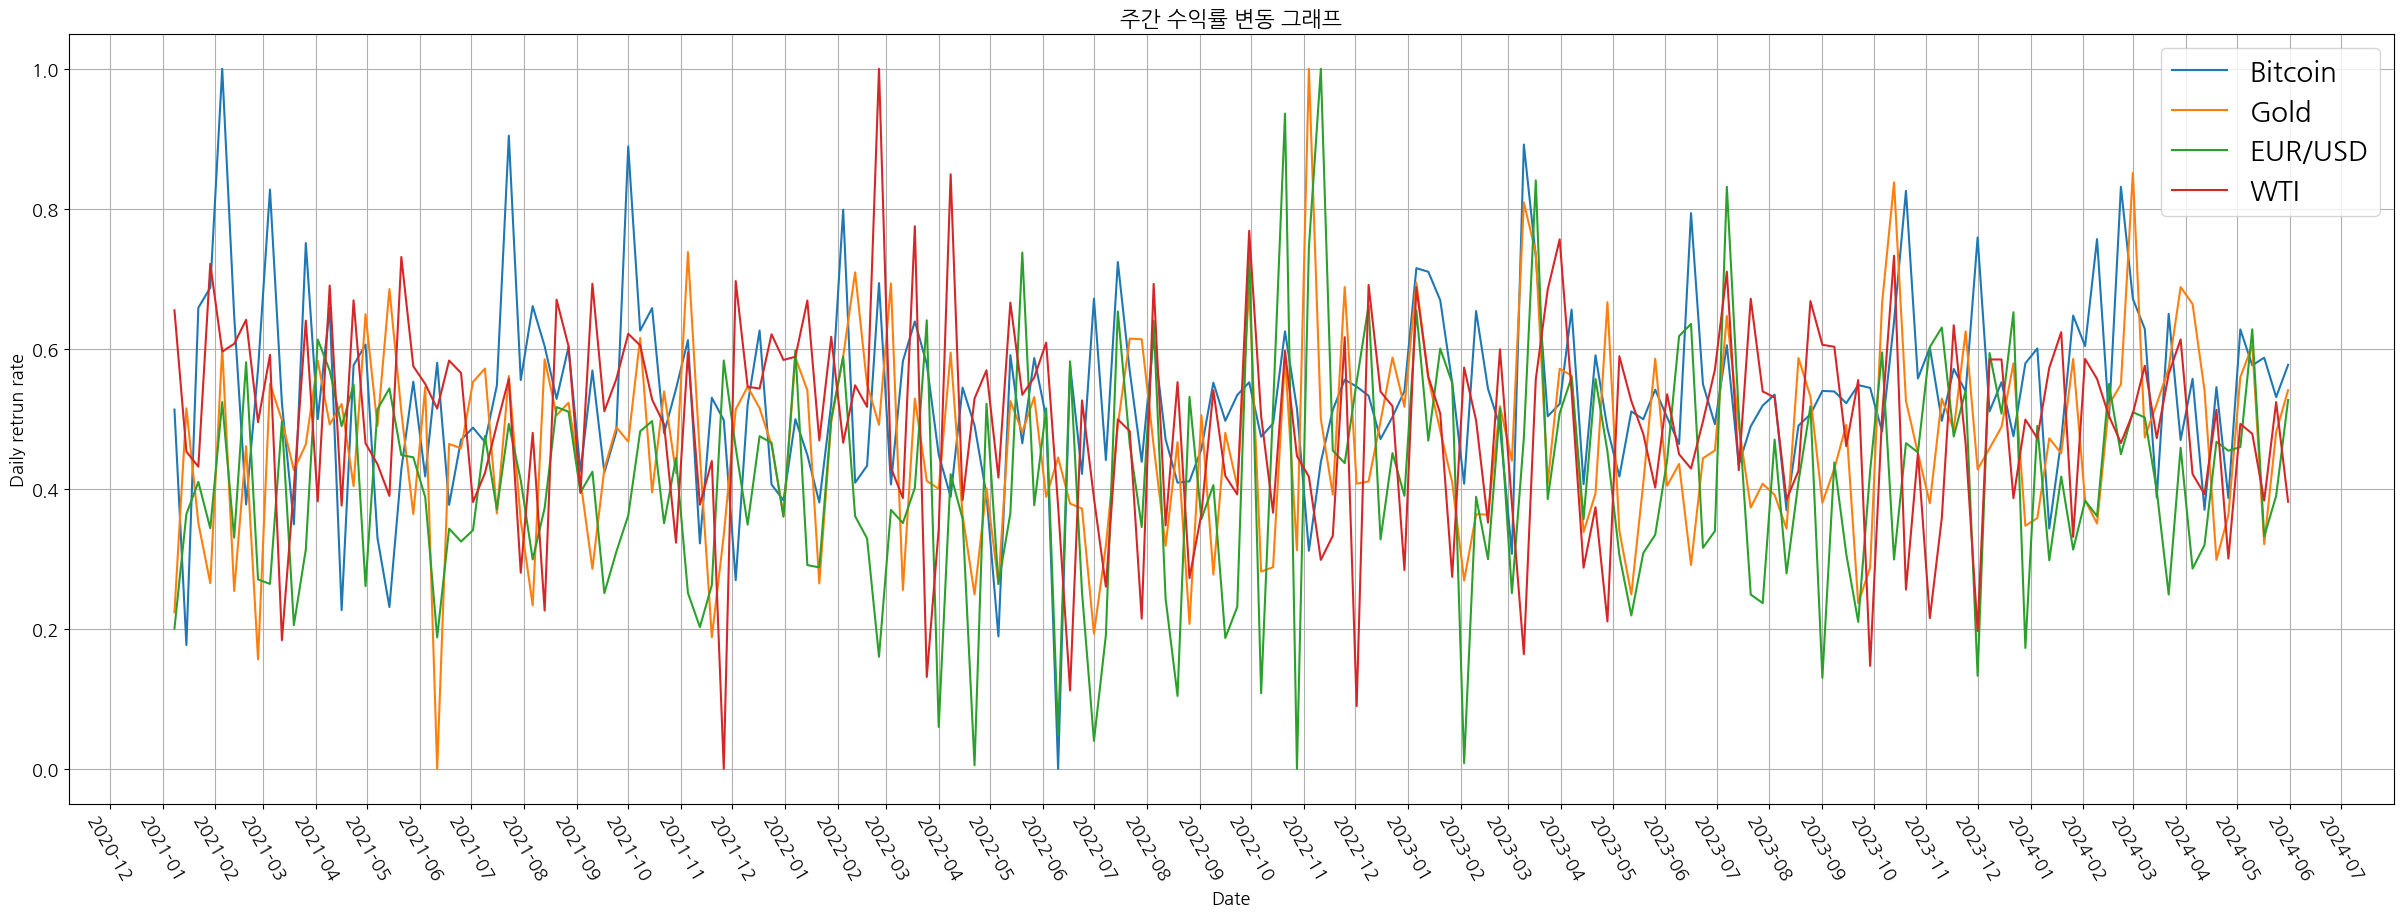

In [9]:
# weekly return rate change graph
# Ï£ºÍ∞Ñ ÏàòÏùµÎ•† (=Ï¶ùÍ∞êÎ•†)Ïùò Î≥ÄÎèôÏÑ± ÌôïÏù∏
# interpolate() : Í≤∞Ï∏°Ïπò Î≥¥Í∞Ñ
w_y1 = weekly_return_rate(bitcoin, start_date, end_date).interpolate()
w_y2 = weekly_return_rate(gold, start_date, end_date).interpolate()
w_y3 = weekly_return_rate(usd, start_date, end_date).interpolate()
w_y4 = weekly_return_rate(wti, start_date, end_date).interpolate()

# Í∞Å Îç∞Ïù¥ÌÑ∞Ïùò Í∏∏Ïù¥Í∞Ä ÏùºÏ†ïÌïòÏßÄ ÏïäÏïÑ, ÌïòÎÇòÏùò DataFrameÏúºÎ°ú Î≥ëÌï© ÌõÑ Í≤∞Ï∏°Ïπò Ï†úÍ±∞
concat_data = pd.concat([w_y1, w_y2, w_y3, w_y4], axis = 1).dropna()

# Î≥ëÌï©Ìïú DataFrameÏúºÎ°ú Ïä§ÏºÄÏùºÎßÅ
scaled_data = scaler.fit_transform(concat_data)

# Extract scaled data for each column
scaled_y1 = scaled_data[:, 0]  # Bitcoin
scaled_y2 = scaled_data[:, 1]  # Gold
scaled_y3 = scaled_data[:, 2]  # EUR/USD
scaled_y4 = scaled_data[:, 3]  # WTI

dates = concat_data.index # ÎÇ†Ïßú Ï∂îÏ∂ú

plt.figure(figsize=(30, 10))
plt.plot(dates, scaled_y1, label = "Bitcoin")
plt.plot(dates, scaled_y2, label = "Gold")
plt.plot(dates, scaled_y3, label = "EUR/USD")
plt.plot(dates, scaled_y4, label = "WTI")

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Daily retrun rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("Ï£ºÍ∞Ñ ÏàòÏùµÎ•† Î≥ÄÎèô Í∑∏ÎûòÌîÑ")
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


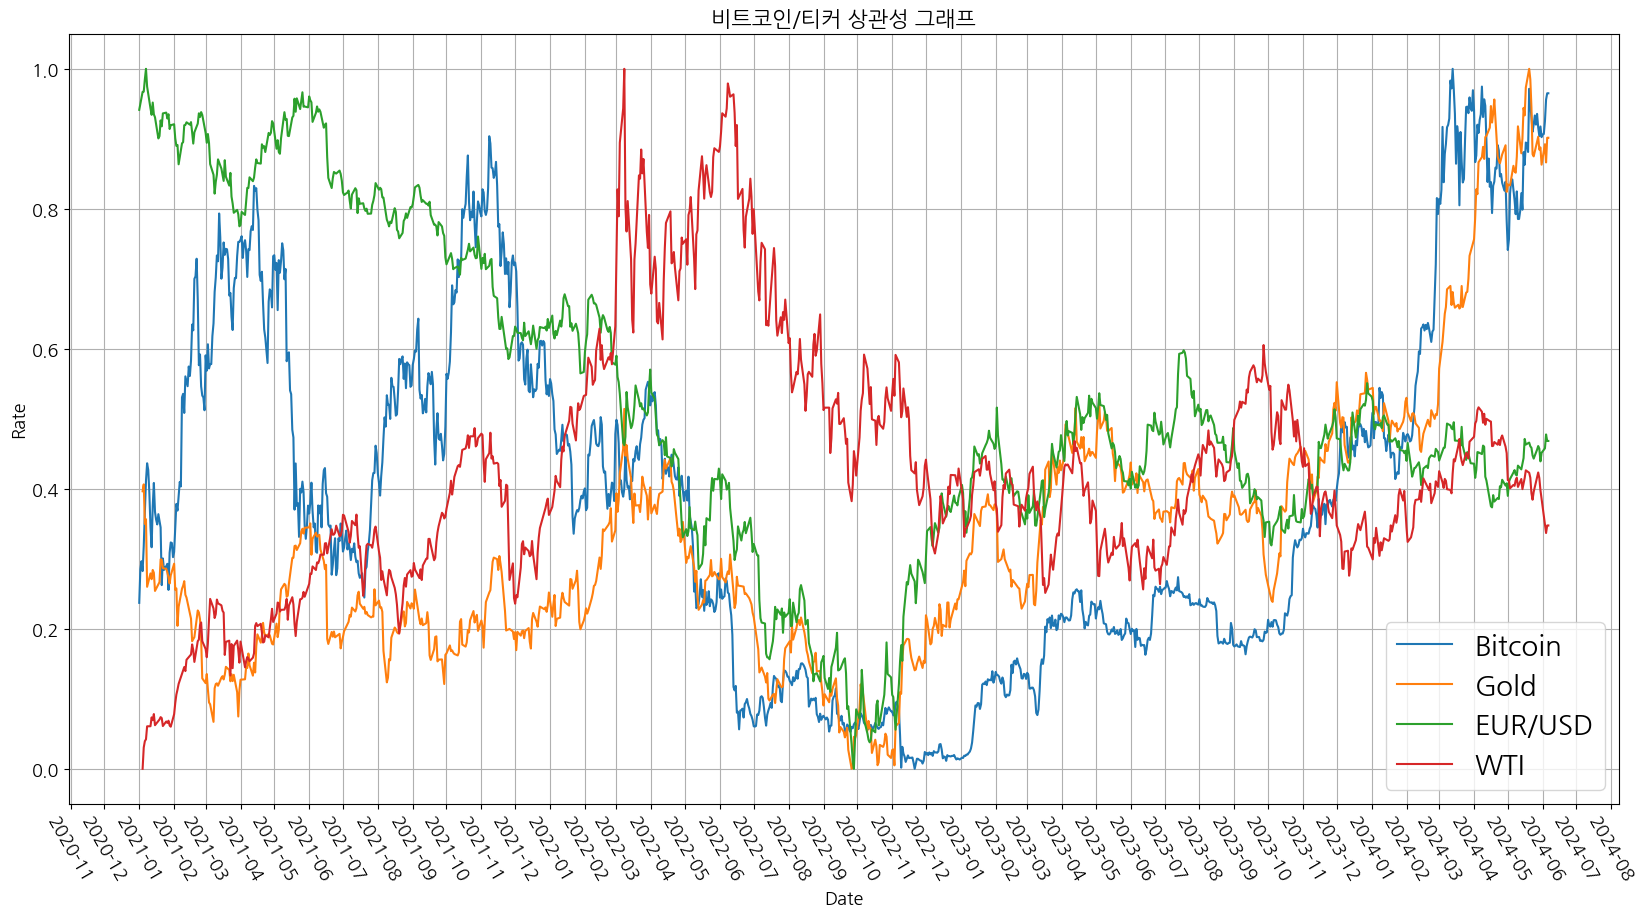

In [10]:
# ÏÉÅÍ¥ÄÏÑ± Í∑∏ÎûòÌîÑ ÏãúÍ∞ÅÌôî
# weekly_return_rate(Bitcoin) / weekly_return_rate(ticker)
corr_y1 = corr_bit(bitcoin, start_date, end_date).reindex(all_dates).interpolate()
corr_y2 = corr_bit(gold, start_date, end_date).reindex(all_dates).interpolate()
corr_y3 = corr_bit(usd, start_date, end_date).reindex(all_dates).interpolate()
corr_y4 = corr_bit(wti, start_date, end_date).reindex(all_dates).interpolate()

y1 = y1_series.values.reshape(-1, 1)
y2 = y2_series.values.reshape(-1, 1)
y3 = y3_series.values.reshape(-1, 1)
y4 = y4_series.values.reshape(-1, 1)

dates = corr_y1.index
plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (20, 10))
plt.plot(dates, scaler.fit_transform(y1), label = "Bitcoin")
plt.plot(dates, scaler.fit_transform(y2), label = "Gold")
plt.plot(dates, scaler.fit_transform(y3), label = "EUR/USD")
plt.plot(dates, scaler.fit_transform(y4), label = "WTI")
plt.legend(loc = "best", prop = {"size" : 20})
plt.xlabel("Date")
plt.ylabel("Rate")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation = 300)
plt.grid(True)
plt.title("ÎπÑÌä∏ÏΩîÏù∏/Ìã∞Ïª§ ÏÉÅÍ¥ÄÏÑ± Í∑∏ÎûòÌîÑ")
plt.show()

## ÌîºÏñ¥Ïä® ÏÉÅÍ¥Ä Í≥ÑÏàò
    - Í∞Å Ï¢ÖÎ™©Îì§ Í∞Ñ ÏÉÅÍ¥Ä Í≥ÑÏàò Î∂ÑÏÑù
    - ÏÉÅÍ¥Ä Í≥ÑÏàòÏùò ÏàòÏπòÍ∞Ä 0.3 ~ 0.7 Ïù¥Î©¥ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÏûàÎã§Í≥† Î¥Ñ (ÏïΩÌï® ~ Ï§ëÍ∞Ñ Ï†ïÎèÑÏùò ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)

In [11]:
# ÎπÑÌä∏ÏΩîÏù∏Í≥º Ìã∞Ïª§Ïùò ÏÉÅÍ¥Ä Í≥ÑÏàò ÏÇ∞Ï∂ú
df_close = pd.concat([bit_ticker["Adj Close"], ticker["Adj Close"]], axis = 1)
df_close.columns = ["bit_adj_close", "tk_adj_close"]
df_close = df_close.dropna()
corr_coefficient = np.corrcoef(df_close["bit_adj_close"], df_close["tk_adj_close"])[0, 1]
print(f"ÎπÑÌä∏ÏΩîÏù∏Í≥ºÏùò ÏÉÅÍ¥Ä Í≥ÑÏàò : {corr_coefficient:.4f}")

ÎπÑÌä∏ÏΩîÏù∏Í≥ºÏùò ÏÉÅÍ¥Ä Í≥ÑÏàò : 0.5073


### üî• HeatMap ÏÉùÏÑ±

#### ‚úÖ ÏïàÏ†Ñ/ÏïàÏ†ïÏ†Å ÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- iShares 20+ Year Treasury Bond ETF : ÎØ∏Íµ≠ Íµ≠Ï±Ñ ETF, ÎØ∏Íµ≠Ïùò Ïû•Í∏∞ Íµ≠Ï±ÑÏóê Ìà¨ÏûêÌïòÏó¨ ÏïàÏ†ïÏ†ÅÏù∏ ÏàòÏùµÏùÑ Ï∂îÍµ¨, Ï¢ÖÎ™©ÏΩîÎìú "TLT"
- iShares iBoxx $ Investment Grade Corporate Bond ETF : ÎØ∏Íµ≠ Ìà¨ÏûêÎì±Í∏â ÌöåÏÇ¨Ï±ÑÏóê Ìà¨ÏûêÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "LQD"
- Duke Energy : Ï†ÑÎ†• Î∞è Ï≤úÏó∞Í∞ÄÏä§ ÏÑúÎπÑÏä§Î•º Ï†úÍ≥µÌïòÎäî Ïú†Ìã∏Î¶¨Ìã∞ Î∂ÄÎ¨∏ Í≥µÍ≥µ Ï£ºÏãù, Ï¢ÖÎ™©ÏΩîÎìú "DUK"
- Gold ETF : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Í∏à Í∞ÄÍ≤©Ïóê Ïó∞ÎèôÎêòÏñ¥ Í∏àÏóê Ìà¨ÏûêÌïòÎäî Ìö®Í≥ºÎ•º Ï†úÍ≥µÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "GLD"

#### ‚úÖ ÏúÑÌóò ÏûêÏÇ∞ ÎπÑÍµêÍµ∞ Ï∂îÍ∞Ä
- Brent oil :  Ï¢ÖÎ™©ÏΩîÎìú "BZ=F"
- Tesla :  Ï¢ÖÎ™©ÏΩîÎìú "TSLA"
- Dow Jones Industrial Average : Îã§Ïö∞Ï°¥Ïä§ ÏÇ∞ÏóÖ ÌèâÍ∑† ÏßÄÏàò, Ï£ºÎ°ú ÎåÄÌòï Í∏∞ÏóÖÎì§Î°ú Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÏñ¥, ÏãúÏû• Ï†ÑÏ≤¥Î≥¥Îã§Îäî Ï£ºÎ°ú ÎåÄÌòïÏ£º Î∞è ÏÇ∞ÏóÖÏùÑ ÎåÄÌëú, Ï¢ÖÎ™©ÏΩîÎìú "^DJI"
- Nasdaq-100 Index : ÎÇòÏä§Îã• 100 ÏßÄÏàòÎ•º Ï∂îÏ¢ÖÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "QQQ"
- Emerging Markets ETF : Ï§ëÍµ≠, Ïù∏ÎèÑ, Î∏åÎùºÏßà Îì± Ïã†Ìù• ÏãúÏû•Ïùò Ï£ºÏãùÏóê Ìà¨ÏûêÌïòÎäî ETF, Ï¢ÖÎ™©ÏΩîÎìú "EEM"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


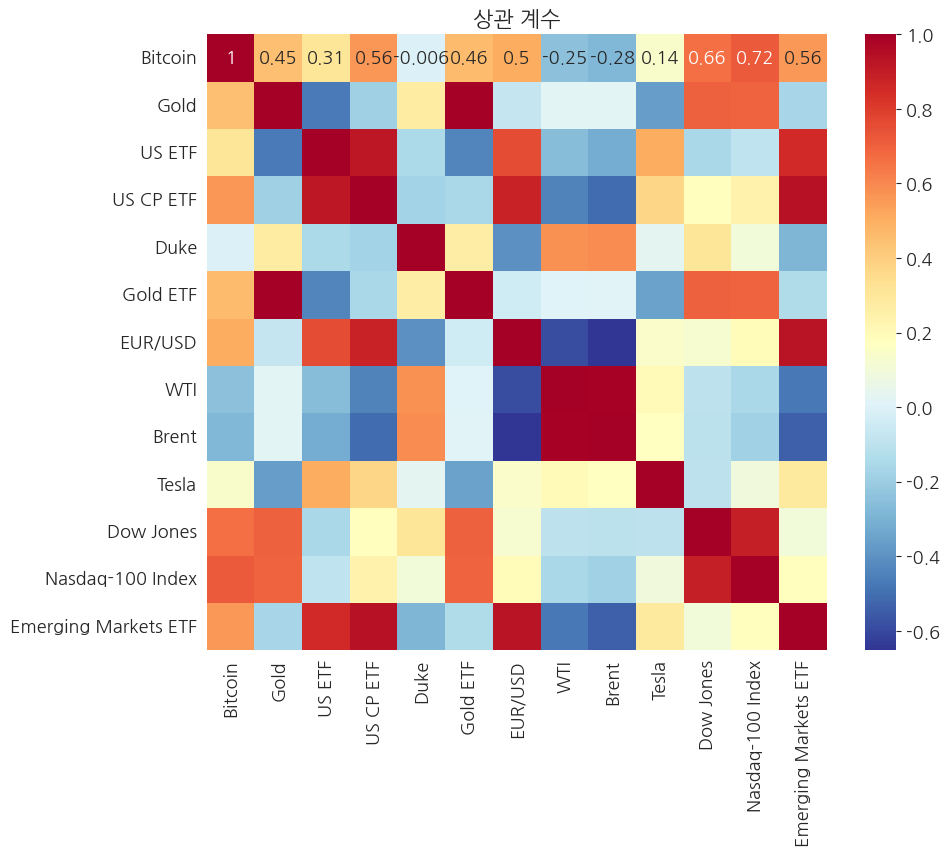

In [12]:
# ÏÉÅÍ¥Ä Í≥ÑÏàò ÏãúÍ∞ÅÌôî - HeatMep
corr_matrix = pd.DataFrame({"Bitcoin" : daily_adj_close(bitcoin, start_date, end_date),
                            # ÏïàÏ†Ñ ÏûêÏÇ∞, ÏïàÏ†ïÏ†Å ÏûêÏÇ∞
                            "Gold" : daily_adj_close(gold, start_date, end_date),
                            "US ETF" : daily_adj_close("TLT", start_date, end_date),
                            "US CP ETF" : daily_adj_close("LQD", start_date, end_date),
                            "Duke" : daily_adj_close("DUK", start_date, end_date),
                            "Gold ETF" : daily_adj_close("GLD", start_date, end_date),
                            "EUR/USD" : daily_adj_close(usd, start_date, end_date),
                            # ÏúÑÌóò ÏûêÏÇ∞
                            "WTI" : daily_adj_close(wti, start_date, end_date),
                            "Brent" : daily_adj_close("BZ=F", start_date, end_date),
                            "Tesla" : daily_adj_close("TSLA", start_date, end_date),
                            "Dow Jones" : daily_adj_close("^DJI", start_date, end_date),
                            "Nasdaq-100 Index" : daily_adj_close("QQQ", start_date, end_date),
                            "Emerging Markets ETF" : daily_adj_close("EEM", start_date, end_date)}).corr()

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, cmap = "RdYlBu_r", cbar = True)
plt.title("ÏÉÅÍ¥Ä Í≥ÑÏàò")
plt.show()

## Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ
- Ìã∞Ïª§Ïùò Î≥ÄÎèôÏÑ±Ïù¥ ÌÅ∞ ÎÇ†ÏßúÏôÄ ÌäπÏ†ï ÎÇ†ÏßúÏùò ÎÑ§Ïù¥Î≤Ñ Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ
- Í≤ÄÏÉâ ÌÇ§ÏõåÎìú : "{Ìã∞Ïª§} ÌôòÏú®/ÏãúÏÑ∏/Í∞ÄÍ≤© Îì±"

In [13]:
# Ï£ºÍ∞Ñ Ìã∞Ïª§ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë
ticker_wk = ticker_data_wk(usd, start_date, end_date)
ticker_wk

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close  Volume  \
Date                                                                    
2021-01-08  1.226873  1.228215  1.211314  1.216249   1.216249       0   
2021-01-15  1.215300  1.217196  1.205545  1.211563   1.211563       0   
2021-01-22  1.216619  1.218800  1.206200  1.210507   1.210507       0   
2021-01-29  1.212136  1.215701  1.196716  1.204239   1.204239       0   
2021-02-05  1.196745  1.215099  1.195357  1.212121   1.212121       0   
...              ...       ...       ...       ...        ...     ...   
2024-05-03  1.073307  1.080941  1.072501  1.074691   1.074691       0   
2024-05-10  1.078516  1.089681  1.076206  1.088981   1.088981       0   
2024-05-17  1.086779  1.089562  1.081303  1.082520   1.082520       0   
2024-05-24  1.081268  1.088945  1.078900  1.080182   1.080182       0   
2024-05-31  1.083541  1.091822  1.081163  1.087453   1.087453       0   

            weekly_return  
Date                       
2021-01-08      -1.447335  
2021-01-15      -0.385283  
2021-01-22      -0.087147  
2021-01-29      -0.517831  
2021-02-05       0.654551  
...                   ...  
2024-05-03       0.236438  
2024-05-10       1.329638  
2024-05-17      -0.593222  
2024-05-24      -0.216026  
2024-05-31       0.673132  

[178 rows x 7 columns]

In [14]:
# ÏÉÅÏäπ, ÌïòÎùΩÏù¥ Í¥ÄÍ≥Ñ ÏóÜÎäî Ï£ºÍ∞Ñ Î≥ÄÎèôÏÑ± Ï∂îÏ∂ú
ticker_chg_abs = (ticker_wk["weekly_return"]).abs()
# Î≥ÄÎèôÏÑ± ÌÅ∞ Íµ¨Í∞Ñ TOP6
large_chg = ticker_chg_abs.sort_values(ascending = False)
top_chg = large_chg[:6]
top_chg

Date
2022-11-11    3.747401
2022-10-21    3.332367
2022-10-28    2.750005
2022-04-22    2.716884
2023-03-17    2.712166
2023-02-03    2.697177
Name: weekly_return, dtype: float64

In [15]:
# Îâ¥Ïä§ ÌÅ¨Î°§ÎßÅ ÎÇ†Ïßú Ï∂îÍ∞Ä
news_date_list = pd.to_datetime(news_date_list, format="%Y.%m.%d").tolist()
top_lst = top_chg.index.to_list()
news_date_list.extend(top_lst)
news_date_list

[Timestamp('2022-03-28 00:00:00'),
 Timestamp('2022-11-14 00:00:00'),
 Timestamp('2023-04-03 00:00:00'),
 Timestamp('2024-01-08 00:00:00'),
 Timestamp('2024-03-25 00:00:00'),
 Timestamp('2024-05-06 00:00:00'),
 Timestamp('2022-11-11 00:00:00'),
 Timestamp('2022-10-21 00:00:00'),
 Timestamp('2022-10-28 00:00:00'),
 Timestamp('2022-04-22 00:00:00'),
 Timestamp('2023-03-17 00:00:00'),
 Timestamp('2023-02-03 00:00:00')]

In [16]:
news_titles = []
search = input("Îâ¥Ïä§ Í≤ÄÏÉâÏñ¥ ÏûÖÎ†• (ex. Îã¨Îü¨ ÌôòÏú®) : ")

driver = wb.Chrome()
driver.maximize_window()
for i in tqdm(range(len(news_date_list))) :
    # Îâ¥Ïä§ Í≤ÄÏÉâ Í∏∞Í∞Ñ : ÏßÄÏ†ïÎêú ÎÇ†Ïßú Ìè¨Ìï® ÏùºÏ£ºÏùº
    news_ds = news_date_list[i]
    news_de = news_ds + datetime.timedelta(days = 6)
    driver.get(f"https://search.naver.com/search.naver?where=news&query={search}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={news_ds.strftime('%Y.%m.%d')}&de={news_de.strftime('%Y.%m.%d')}&docid=&related=0&mynews=0&office_type=0&office_section_code=0")
    
    body = driver.find_element(By.TAG_NAME, "body")
    try :
        # Ïä§ÌÅ¨Î°§
        for _ in range(10) :
            body.send_keys(Keys.END)
            time.sleep(1)
            
        # Îâ¥Ïä§ ÌÉÄÏù¥ÌãÄ ÏàòÏßë
        titles = driver.find_elements(By.CSS_SELECTOR, "a.news_tit")
        for i in titles :
            news_titles.append(i.text)
    except Exception as e :
        print("Ïò§Î•ò : ", e)
print("ÏôÑÎ£åüòá")
driver.quit()

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [02:28<00:00, 12.35s/it]


ÏôÑÎ£åüòá


In [17]:
print(len(news_titles))
print(news_titles)

1160
["Áæé Fed 'ÎπÖÏä§ÌÖù' ÏòàÍ≥†‚Ä¶ÌïòÎ∞òÍ∏∞ Ïò§ÌûàÎ†§ Îã¨Îü¨ÏïΩÏÑ∏ Ïò¨ ÏàòÎèÑ", 'Ïõê/Îã¨Îü¨ ÌôòÏú® ÏÉÅÏäπÏÑ∏‚Ä¶1,210ÏõêÎåÄ Ï§ëÌõÑÎ∞ò', "'Îã¨Îü¨Îãπ 124Ïóî' ÏïàÏ†ÑÏûêÏÇ∞ ÏóîÌôîÏùò Ï∂îÎùΩ‚Ä¶Êó•Ïóê Î¨¥Ïä® ÏùºÏù¥[Ïù¥ÏßÄÍ≤ΩÏ†ú]", 'TIGER ÎØ∏Íµ≠Îã¨Îü¨Îã®Í∏∞Ï±ÑÍ∂åÏï°Ìã∞Î∏å ETF ÏàúÏûêÏÇ∞ 3000Ïñµ ÎèåÌåå', '[Ïô∏ÌôòÎ∏åÎ¶¨Ìïë]Îã¨Îü¨ ÏïΩÏÑ∏vsÏúÑÌóò ÌöåÌîº‚Ä¶ÌôòÏú®, 1200ÏõêÎåÄ Í≥µÎ∞© ÏòàÏÉÅ', 'ÏõêÎã¨Îü¨ÌôòÏú® 1209.6Ïõê ÎßàÍ∞ê', 'Ïö∞ÌÅ¨Îùº ÌèâÌôîÌòëÏÉÅ ÏßÑÏ†ÑÏóê Ïõê¬∑Îã¨Îü¨ ÌôòÏú® 10Ïõê Í∏âÎùΩÌïú 1209.6Ïõê', '[Ïò§ÎäòÏùò ÌôòÏú®Ï†ÑÎßù] Îã¨Îü¨ ÏúÑÌóòÌöåÌîºÏÑ±Ìñ•Ïóê ÏÉÅÏäπ‚Ä¶ 2Ïõê ÏÉÅÏäπ Ï∂úÎ∞ú ÏòàÏÉÅ', 'ÏõêÎã¨Îü¨ ÌôòÏú® Îã§Ïãú 1220ÏõêÎåÄÎ°ú(Ï¢ÖÌï©)', 'Ïõê/Îã¨Îü¨ ÌôòÏú® Î≥¥Ìï©ÏÑ∏‚Ä¶1,210ÏõêÏÑ† Îì±ÎùΩ', 'Ïõê Îã¨Îü¨ ÌôòÏú® ÏÉÅÏäπ ÎßàÍ∞ê', 'Ïõê/Îã¨Îü¨ ÌôòÏú® 2.5Ïõê Ïò§Î•∏ 1,212ÏõêÏóê ÎßàÍ∞ê', 'Ïù¥Ï∞ΩÏö© "ÎπÑÎëòÍ∏∞ÌååÎèÑ Îß§ÌååÎèÑ Îê† Ïàò ÏûàÎã§‚Ä¶ÌôòÏú® ÏÉÅÏäπ, Î¨ºÍ∞Ä ÏûêÍ∑π Ïö∞Î†§"', 'Ïö∞ÌÅ¨Îùº ÌòëÏÉÅ Í∏∞ÎåÄÏóê Ïõê/Îã¨Îü¨ ÌôòÏú® 1,220Ïõê Î∞ëÏúºÎ°ú', '[ÌôòÏú®ÎßàÍ∞ê] Ïõê/Îã¨Îü¨ ÌôòÏú®, 3.4Ïõê Ïò§Î•∏ 1215.5Ïõ

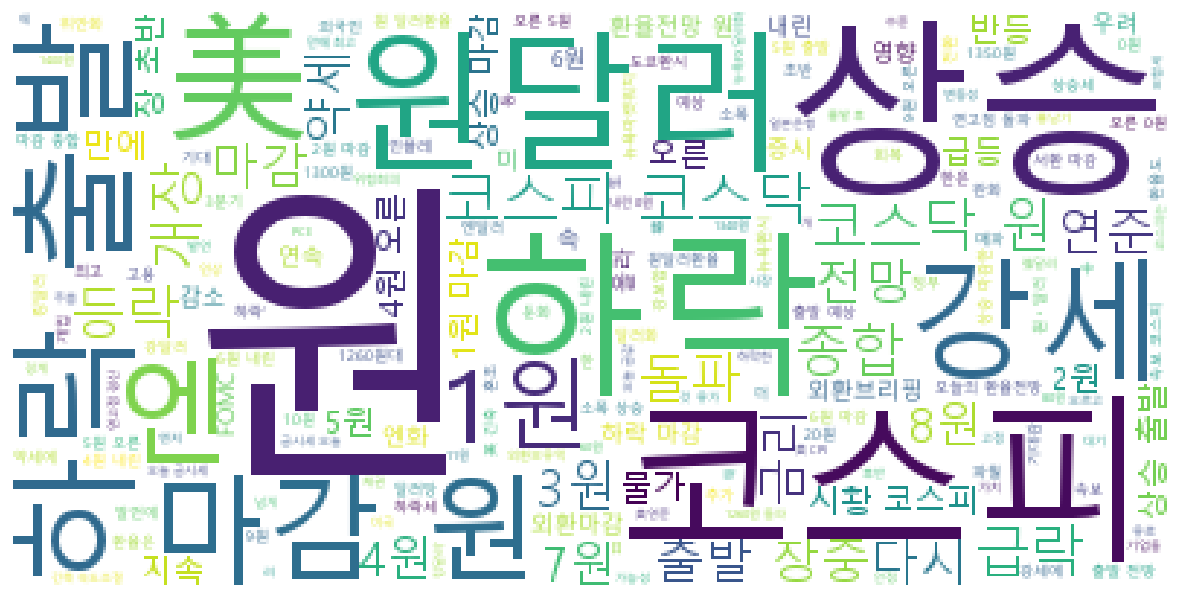

In [19]:
# ÏõåÎìúÌÅ¥ÎùºÏö∞ÎìúÎ•º ÌÜµÌïú ÌïµÏã¨ ÌÇ§ÏõåÎìú ÏãúÍ∞ÅÌôî
text = ",".join(news_titles)
f_path = "C:\Windows\Fonts\malgun.ttf"

wc = WordCloud(font_path = f_path, random_state = 42, background_color = "white")
wc.generate(text)
plt.figure(figsize = (15, 10))
plt.axis("off")
plt.imshow(wc, interpolation = "None")
plt.show()